# Comparative Static Analysis Keane and Wolpin (1994)

### Baseline parametrization

In the following we present the key ingredients of the parametrization:

- Schooling increases wages by 4% in occupation a (blue collar).
- Schooling increases wages by 8% in occupation b (white collar).
- Consumption value of schooling of $\$$5,000.
- Once left school, $\$$15,000 cost of re-enrollment.
- Individuals are forward-looking and $\delta$ = 0.95.
- Random shocks are not correlated across alternatives.

In [81]:
import respy as rp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Simulation

Life-cycle histories of 1,000 individuals for 40 periods are simulated.

In [82]:
NUM_AGENTS = 1000
NUM_PERIODS = 40

# Load example model and convert parameter and options to model attributes.
params, options = rp.get_example_model("kw_94_two", with_data=False)
options["simulation_agents"] = NUM_AGENTS
options["n_periods"] = NUM_PERIODS

In [83]:
ret_schooling = {
    "blue_collar": params.loc[("wage_a", "exp_edu"), "value"],  # occupation "b"
    "white_collar": params.loc[("wage_b", "exp_edu"), "value"]  # occupation "a"
}
print(ret_schooling)

{'blue_collar': 0.04, 'white_collar': 0.08}


In [4]:
simulate_base = rp.get_simulate_func(params, options)
df_base = simulate_base(params)

In [5]:
experience = {
    "School": df_base.groupby("Identifier")["Experience_Edu"].max().mean(),
    "White": df_base.groupby("Identifier")["Experience_B"].max().mean(),  # white collar
    "Blue": df_base.groupby("Identifier")["Experience_A"].max().mean(),  # blue collar
}
experience

{'School': 12.438, 'White': 10.998, 'Blue': 23.122}

### Choice patterns for Keane and Wolpin (1994)

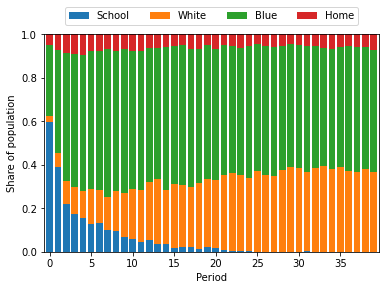

In [7]:
fig, ax = plt.subplots()

shares = df_base.groupby("Period").Choice.value_counts(normalize=True).unstack()[
    ["edu", "b", "a", "home"]
]
labs = ["School", "White", "Blue", "Home"]

shares.plot.bar(stacked=True, ax=ax, width = 0.8)

ax.legend(
    labels = labs,
    loc = "upper center", 
    bbox_to_anchor=(0.5, 1.15),
    ncol = len(labs)
)

# x-axis options
ax.set_xticks(range(0, options["n_periods"], 5))
ax.set_xticklabels(range(0, options["n_periods"], 5), rotation="horizontal")

# y-axis options
ax.set_ylim(0,1)
ax.set_ylabel("Share of population");

## Comparative Statics: Let Ambiguity In!
---

We study the comparative statics of the model for three ambiguity scenarios. The extent of ambiguity is given by the size of the so-called "ambiguity-set", which is in turn governed by the parameter $\eta$. We will compare three ambiguity scenarios:
- risk-only (absent) model $\eta$ = 0.00
- low level of ambiguity $\eta$ = 0.01
- high level of ambiguity $\eta$ = 0.02

*Note:* There is no clear interpretation of what the terms "low" and "high" mean. At this point we will use them for labelling purposes only.

In [28]:
ambiguity_values = {
    "absent": 0.00,
    "low": 0.1,
    "high": 0.2,
}

ambiguity_labels = list(ambiguity_values.keys())

# Initialize containers for the analysis
effect_ambiguity_set = {}

In [18]:
ambiguity_values

{'absent': 0.0, 'low': 0.1, 'high': 0.2}

Get the Keane and Wolpin (1994) specification and add ambiguity to it. We will build the simulate function based on our parameters. Note that the `simulate` function can be reused because only parameters change in the simulation.

In [19]:
params, options, _ = rp.get_example_model("kw_94_two")
options["simulation_agents"] = NUM_AGENTS
options["n_periods"] = NUM_PERIODS

params.loc[("eta", "eta"), "value"] = 0.00
simulate = rp.get_simulate_func(params, options)

For each ambiguity level (absent, low, high) simulate and solve the model.

In [20]:
data_frames_ambiguity = []

for ambiguity_level in ambiguity_labels:
    params, _, _ = rp.get_example_model("kw_94_two")
    params.loc[("eta", "eta"), :] = ambiguity_values[ambiguity_level]
    simulate = rp.get_simulate_func(params, options)
    print("Current ambiguity value:", params.loc[("eta", "eta"), "value"], ".")
    data_frames_ambiguity.append(simulate(params))

Current ambiguity value: 0.0 .
Current ambiguity value: 0.1 .
Current ambiguity value: 0.2 .


In [21]:
ambiguity_values


{'absent': 0.0, 'low': 0.1, 'high': 0.2}

### Effect of Ambiguity Set on average year of experience

Assemble the effect of the ambiguity set on the average years an individual spends in each of the four alternatives.


In [38]:
for df, ambiguity_level in zip(data_frames_ambiguity, ambiguity_labels):
    exp_edu = df.groupby("Identifier")["Experience_Edu"].max().mean()
    exp_b = df.groupby("Identifier")["Experience_B"].max().mean()  # white collar
    exp_a = df.groupby("Identifier")["Experience_A"].max().mean()  # blue collar
    
    effect_ambiguity_set[ambiguity_level] = [
        exp_edu,
        exp_b, 
        exp_a,
        50 - exp_edu - exp_a - exp_b
    ]

In [23]:
df_effect_ambiguity_set = pd.DataFrame.from_dict(effect_ambiguity_set, orient="index")
df_effect_ambiguity_set.rename(
    columns={0: "School", 1: "White", 2: "Blue", 3: "Home"}
         )

,School,White,Blue,Home
absent,12.438,10.998,23.122,3.442
low,12.438,10.998,23.122,3.442
high,12.438,10.998,23.122,3.442


Of course - this crap is simply WRONG

We calculate the time spent at home via the difference `Home` = 50 - `Experience_Edu` - `Experience_B` - `Experience_A`.

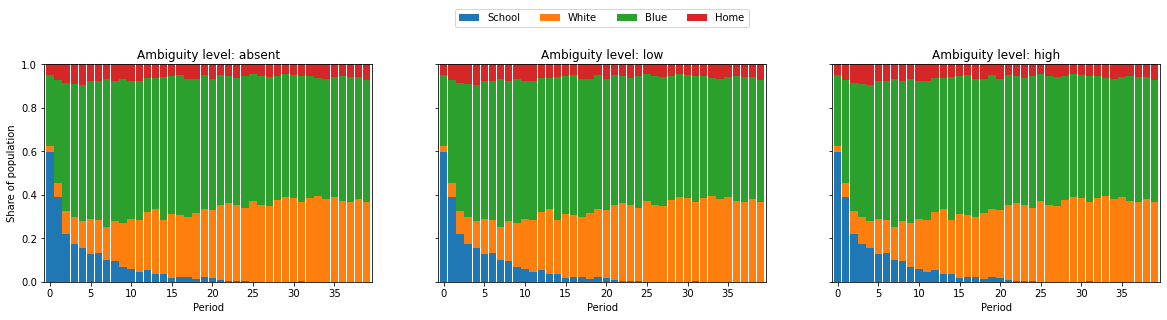

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharey=True, sharex=True)

axs = axs.flatten()

for df, ax, ambiguity_label in zip(data_frames_ambiguity, axs, ambiguity_labels):
    shares = df.groupby("Period").Choice.value_counts(normalize=True).unstack()[
        ["edu", "b", "a", "home"]
    ]

    shares.plot.bar(stacked=True, ax=ax, width=0.9, legend=True)

    ax.set_ylim(0, 1)
    ax.set_ylabel("Share of individuals")
    
    ax.set_xticks(range(0, 40, 5))
    ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(f"Ambiguity level: {ambiguity_label}")
    
# Assmble the legend of the figure    
fig.legend(
    handles,
    labs,
    loc="lower center",
    bbox_to_anchor=(0.418, 1),
    ncol=4
);

### Expected Utility Loss

For each ambiguity scenario we compute the loss in expected total discounted utility for an individual entering the model. We compare it to the work without any ambiguity at all, referred to "risk-only" world.

## Comparative Statics: Let Ambiguity and Tuition Subsidies In!
---

We will still consider our three ambiguity scenarios absent, low, and high. However, for each of those scenarios we will compare the effect of a tuition subsidy worth $\$$1,000.

In [35]:
TUITION_SUBSIDIES = [0, 1000]

ambiguities = np.repeat(list(ambiguity_values.values()), len(TUITION_SUBSIDIES))
tuition_subsidies = len(ambiguity_values) * TUITION_SUBSIDIES

effect_ambiguity_set_subsidy = {}

In [36]:
data_frames_ambiguity_subsidies = []

for ambiguity_level, tuition_subsidy in zip(ambiguities, tuition_subsidies): 
    params, _, _ = rp.get_example_model("kw_94_two")
    params.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] += tuition_subsidy
    params.loc[("eta", "eta"), "value"] = ambiguity_level
    data_frames_ambiguity_subsidies.append(simulate(params))

In [80]:
df_ambiguity_subsidies_zero = [
    data_frames_ambiguity_subsidies[2*i] 
    for i in range(0, len(list(ambiguity_values.values())))
]

df_ambiguity_subsidies_nonzero = [
    data_frames_ambiguity_subsidies[2*i+1] 
    for i in range(0,len(list(ambiguity_values.values())))
]

In [52]:
for df_zero, df, ambiguity_label in zip(
    df_ambiguity_subsidies_zero, 
    df_ambiguity_subsidies_nonzero,
    ambiguity_labels):
    
    exp_edu_zero = df_zero.groupby("Identifier")["Experience_Edu"].max().mean()
    exp_b_zero = df_zero.groupby("Identifier")["Experience_B"].max().mean()  # white collar
    exp_a_zero = df_zero.groupby("Identifier")["Experience_A"].max().mean()  # blue collar
    
    exp_edu = df.groupby("Identifier")["Experience_Edu"].max().mean()
    exp_b = df.groupby("Identifier")["Experience_B"].max().mean()  # white collar
    exp_a = df.groupby("Identifier")["Experience_A"].max().mean()  # blue collar
    
    effect_ambiguity_set_subsidy[ambiguity_label] = {
        "0": {"Edu":exp_edu, "White":exp_b, "Blue": exp_a, "Home": 50 - exp_edu - exp_a - exp_b},
        "1000": {"Edu": exp_edu_zero, "White": exp_b_zero, "Blue": exp_a_zero, "Home": 50 - exp_edu_zero - exp_a_zero - exp_b_zero}, 
    }

In [75]:
df_effect_ambiguity_set_subsidy = pd.DataFrame.from_dict(
    {(i,j): effect_ambiguity_set_subsidy[i][j] 
     for i in effect_ambiguity_set_subsidy.keys() 
     for j in effect_ambiguity_set_subsidy[i].keys()},
    orient='index')

In [76]:
df_effect_ambiguity_set_subsidy

Edu   White    Blue   Home
absent 0     13.677  13.310  20.086  2.927
       1000  12.438  10.998  23.122  3.442
low    0     13.677  13.310  20.086  2.927
       1000  12.438  10.998  23.122  3.442
high   0     13.677  13.310  20.086  2.927
       1000  12.438  10.998  23.122  3.442

#### Examples for indexing above dataframe

In [78]:
print(df_effect_ambiguity_set_subsidy.loc[("absent", "1000"), "Edu"])
print(df_effect_ambiguity_set_subsidy[["Edu", "White"]].loc["absent"])

12.438
         Edu   White
0     13.677  13.310
1000  12.438  10.998


#### Illustration

In [90]:
ambiguities

array([0. , 0. , 0.1, 0.1, 0.2, 0.2])

array(['absent', 'absent', 'low', 'low', 'high', 'high'], dtype='<U6')

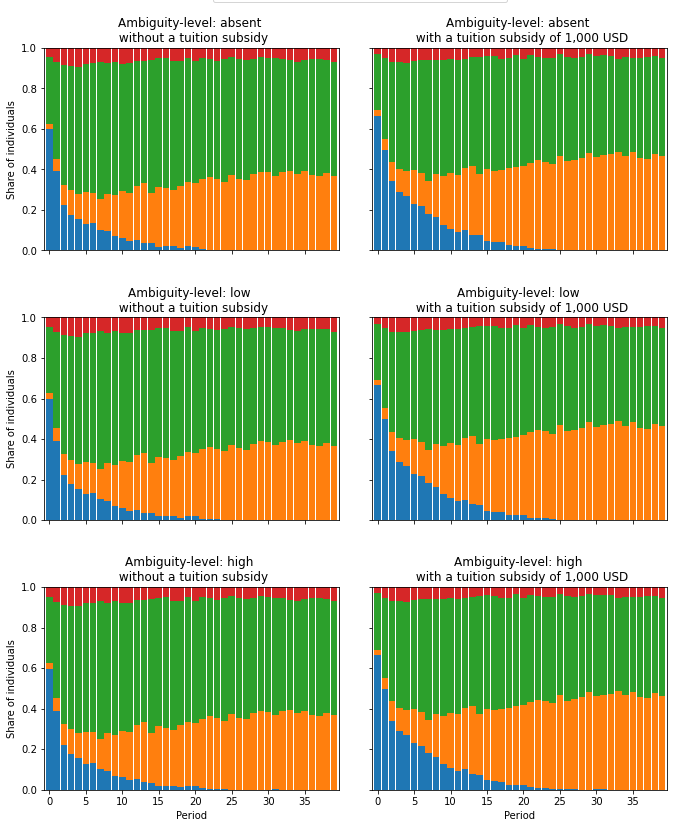

In [142]:
fig, axs = plt.subplots(
    len(list(ambiguity_values.values())),  # amount of ambiguity values we are considering
    len(TUITION_SUBSIDIES),  # how many tuition subsidies we consider (0 included)
    figsize=(10, 12), 
    sharey=True, 
    sharex=True
)

axs = axs.flatten()
ambiguities_labels = np.repeat(ambiguity_labels, len(TUITION_SUBSIDIES))

for df, ax, ambiguity_label, tuition_subsidy in zip(data_frames_ambiguity_subsidies, axs, ambiguities_labels, tuition_subsidies):
    shares = df.groupby("Period").Choice.value_counts(normalize=True).unstack()[
        ["edu", "b", "a", "home"]
    ]

    shares.plot.bar(stacked=True, ax=ax, width=0.9, legend=True)

    ax.set_ylim(0, 1)
    ax.set_ylabel("Share of individuals")
        
    ax.set_xticks(range(0, 40, 5))
    ax.set_xticklabels(range(0, 40, 5), rotation="horizontal")
   
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if tuition_subsidy:
        label = f"with a tuition subsidy of {tuition_subsidy:,} USD"
    else:
        label = "without a tuition subsidy"
    ax.set_title(f"Ambiguity-level: {ambiguity_label} \n {label}")
     
fig.legend(
    handles,
    labs,
    bbox_to_anchor=(0.5, 0.95), 
    loc='lower center',
    ncol=4
)

fig.subplots_adjust(bottom=0.2)
fig.tight_layout(pad=3.0);


#### List of state variables

In [ ]:
for col in df_base.columns: 
    print(col) 

## References

> Keane, M. P. and  Wolpin, K. I. (1994). [The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence](https://doi.org/10.2307/2109768). *The Review of Economics and Statistics*, 76(4): 648-672.